<a href="https://colab.research.google.com/github/MeldaChen/Group-4/blob/main/image_find_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

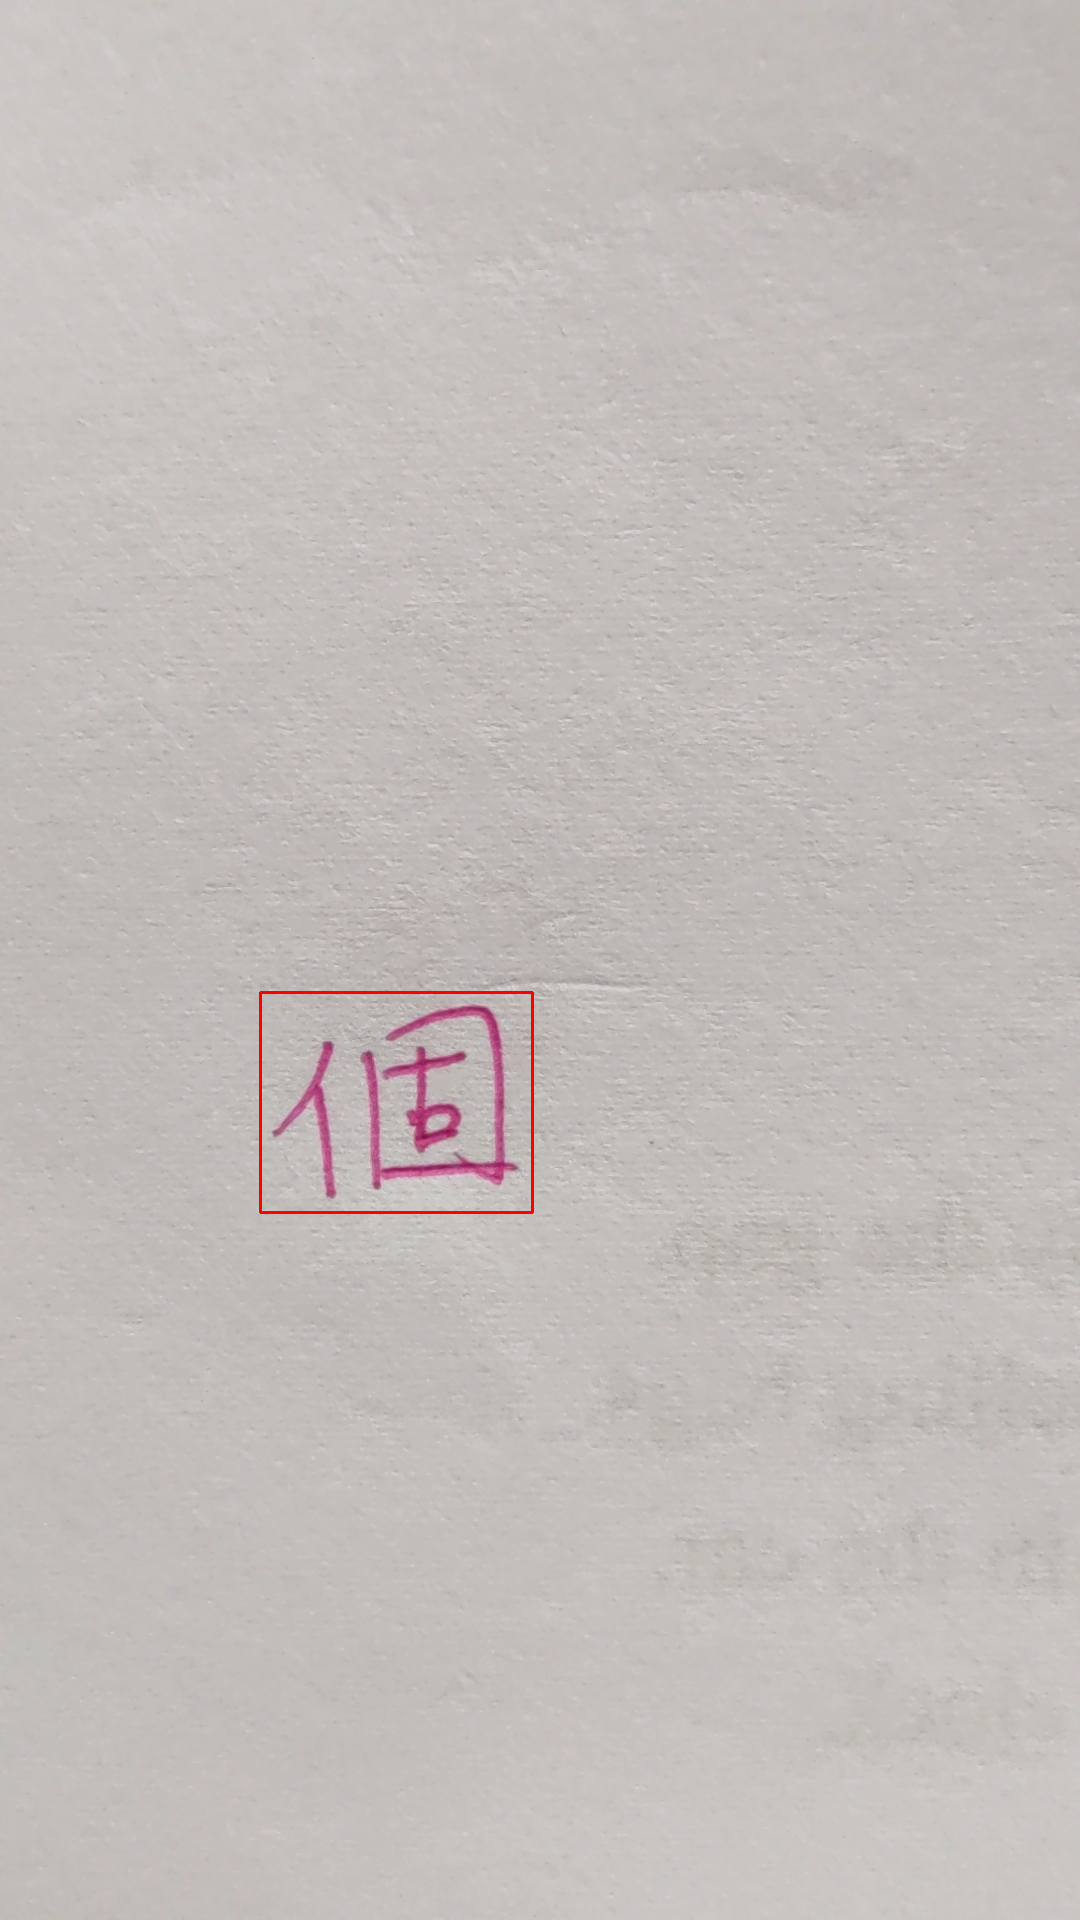

---------


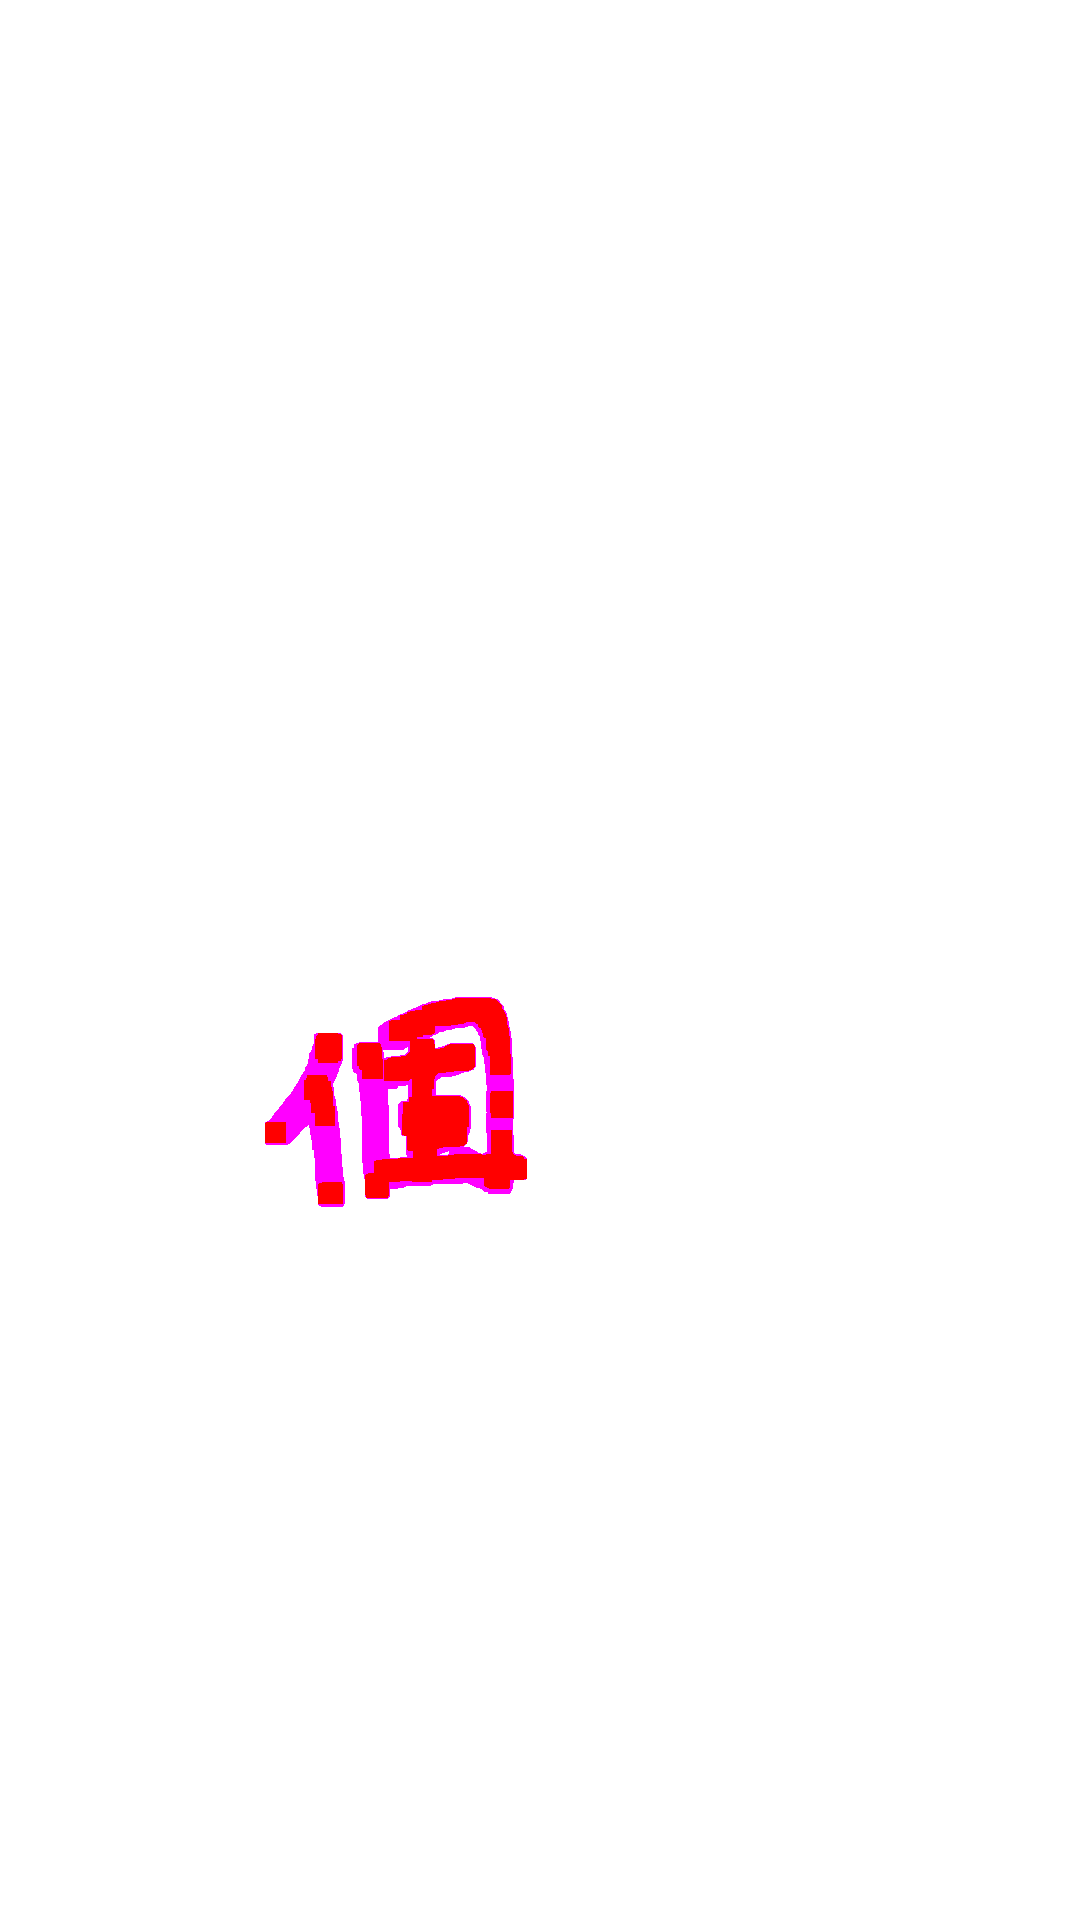

---------


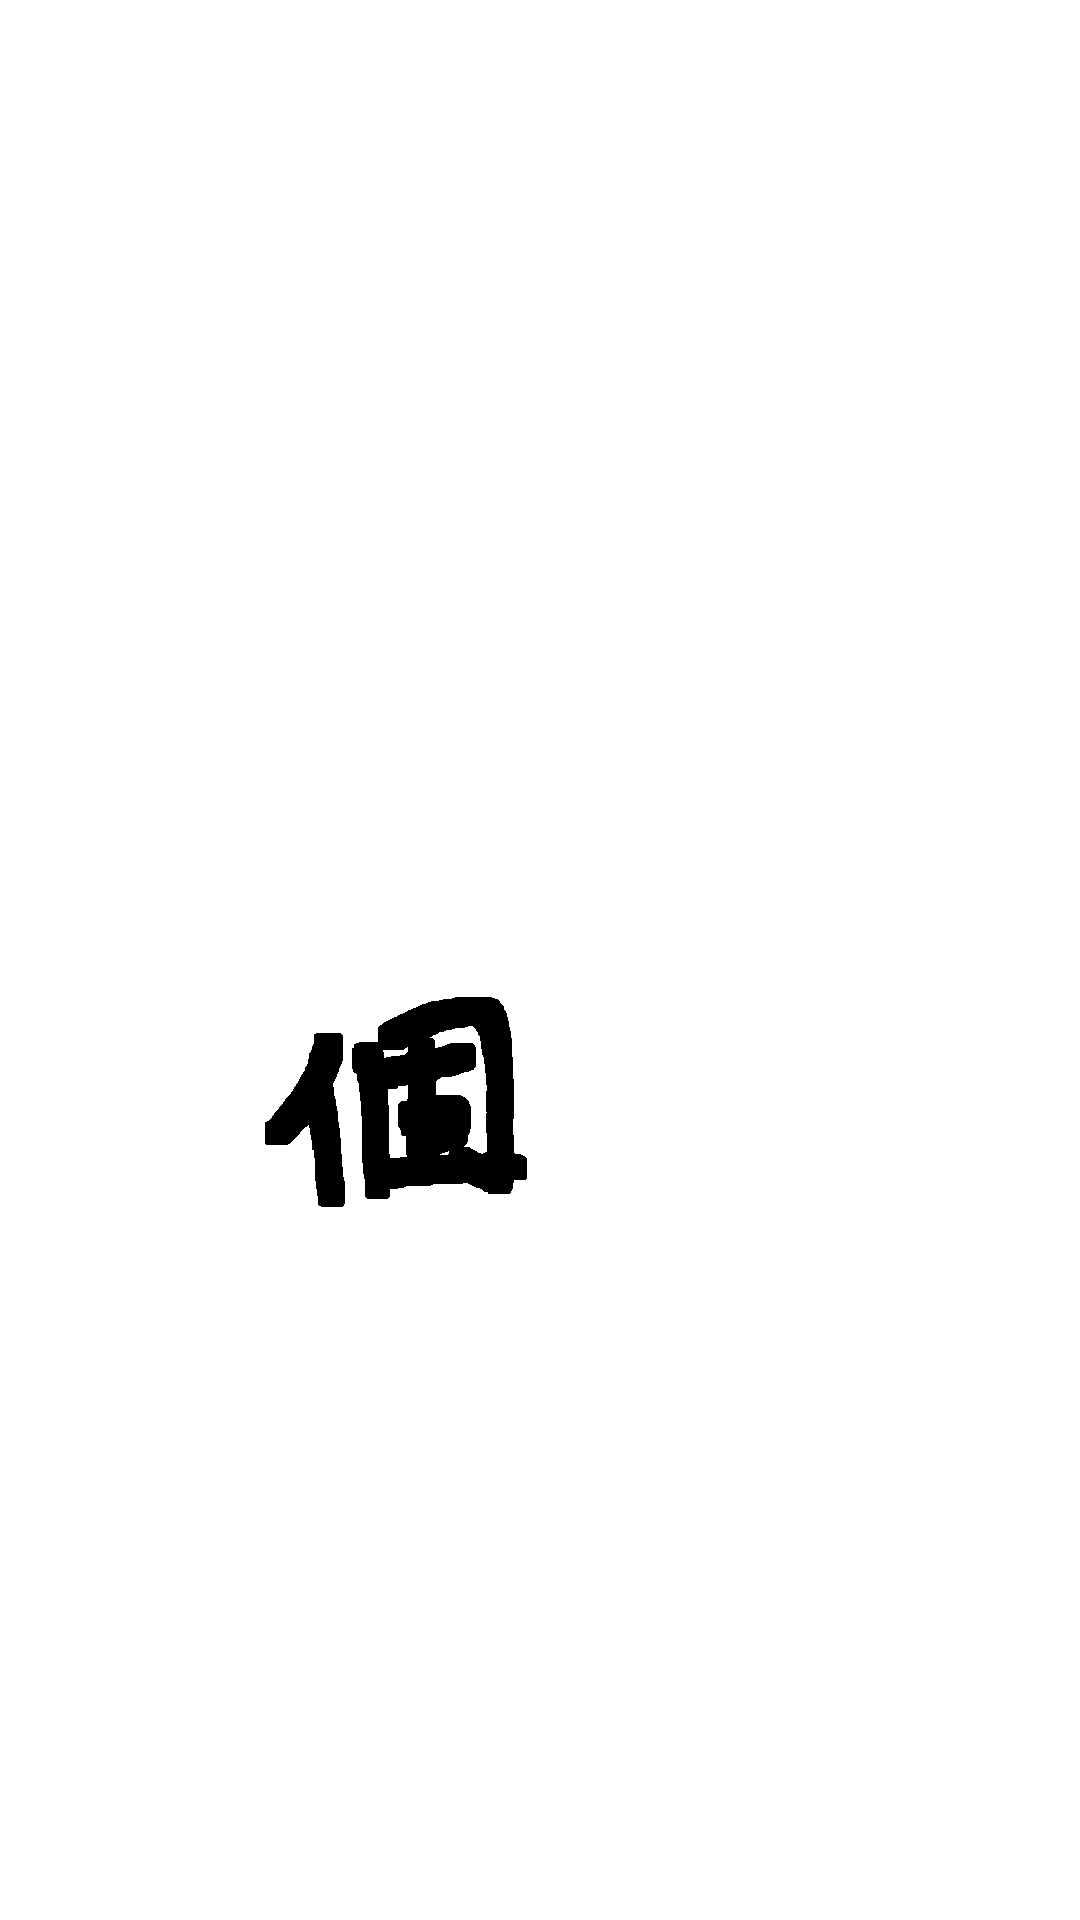

In [31]:
# 裁切等辨識後再裁？
# 分開的字如何框在一起，如 e024 個
# 明亮度、模糊化

import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow

m1 = cv2.imread('A024.jpg', 1)

copy = m1.copy()

erode = cv2.erode(copy, np.ones((20, 20))) #抓字

th, thres = cv2.threshold(erode, 110, 255, cv2.THRESH_BINARY) #二值化去背



gray = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY) #轉灰階

th, thres_2 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) #二值化去背again

canny = cv2.Canny(thres_2, 0, 90)

th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 

for i in range(0, len(p), 1): 
    x, y, w, h = cv2.boundingRect(p[i]) 
    cv2.rectangle(m1, (x,y), (x+w, y+h), (0, 0, 255), 2)

cv2_imshow(m1)
print("---------")
cv2_imshow(thres)
print("---------")
cv2_imshow(thres_2)
# print("---------")
# cv2_imshow(m4)
# print("---------")


In [ ]:
# 裁切等辨識後再裁？


import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow

m1 = cv2.imread('C037.jpg', 1)

m2 = m1.copy()

m2 = cv2.erode(m2, np.ones((3, 3))) #字加粗

th, m3 = cv2.threshold(m2, 110, 255, cv2.THRESH_BINARY) #二值化去背

m4 = cv2.cvtColor(m3, cv2.COLOR_BGR2GRAY) #轉灰階

edged = cv2.Canny(m4, 50, 100)

(_, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

coins = m4.copy()

cv2.drawContours(coins, cnts, -1, (0, 255, 0), 2)


displayIMG(coins, “Coins")

cv2_imshow(m1)
# print("---------")
# cv2_imshow(m2)
# print("---------")
# cv2_imshow(m3)
# print("---------")
# cv2_imshow(m4)
print("---------")
cv2_imshow(coins)
print("---------")

ValueError: ignored

In [ ]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow

m1 = cv2.imread('IMG_1266.jpg', 1)
# 讀取中文路徑圖檔(圖片讀取為BGR)
def cv_imread():
    image = cv2.imdecode(np.fromfile("e098.jpg", dtype=np.uint8), -1)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    return image

# 顯示圖檔
def show_img(name, image):
    cv2.imshow(name, image)
    cv2.waitKey(0)

# 圖片預處理
def preprocessing(image):
    # 灰階
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    show_img('gray', gray)

    # 高斯濾波
    gaussian = cv2.GaussianBlur(gray, (9, 9), 0)
    show_img("gaussian", gaussian)

    # 開運算去除白色噪點
    kernel = np.ones((9, 9), np.uint8)
    open = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, 
                            kernel, iterations=3)
    show_img("open", open)
    return open

# 計算物體中間點
def midpoint(point1, point2):
    point = ((point1[0]+point2[0])/2, (point1[1]+point2[1])/2)
    return point

def edge_detect(image):
    # 以canny邊緣檢測算法獲取目標(50~100為閾值)
    edged = cv2.Canny(image, 50, 100) #低於50刪除 高於100留下
    show_img("edged", edged)

    # 在邊緣圖像中尋找物體輪廓
    contours1, hierarchy = cv2.findContours(edged.copy(), 
                                            cv2.RETR_EXTERNAL,
                                            cv2.CHAIN_APPROX_SIMPLE)
    # 物體輪廓由左到右進行排序
    (contours2, _) = contours.sort_contours(contours1)
    # 若輪廓面積小於100，視為噪音濾除
    contours2 = [i for i in contours2 if cv2.contourArea(i) > 100]

    # 初始化 pixels per metric
    pixelsPerMetric = None

    return contours2, pixelsPerMetric

# 計算物體像素尺寸，並轉換為實際尺寸
def measure(image, contours2, pixelsPerMetric):
    origin = image.copy()
    for i in contours2:
        # 計算出物品輪廓之外切線框
        box = cv2.minAreaRect(i)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() \
              else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # 左上角座標開始順時針排序，並畫出外切線框
        box = perspective.order_points(box)
        cv2.drawContours(origin, [box.astype("int")], -1, (0, 255, 0), 2)

        # 畫書外切線框端點
        for (x, y) in box:
            cv2.circle(origin, (int(x), int(y)), 5, (0, 0, 255), -1)

        # 算出左上和右上端點的中心點、左下和右下端點的中心點
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        # 算出左上和左下端點的中心點、右上和右下端點的中心點
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        # 計算兩個中心點距離(dA：寬、dB：長)
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # 像素值與最左邊物品實際長度比值
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / image_width

        # 計算目標的實際大小
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric

        # 在圖片中標註物體尺寸
        cv2.putText(origin, "{:.1f}cm".format(dimB),
                    (int(tltrX - 15), int(tltrY - 10)), 
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (255, 255, 255), 2)
        cv2.putText(origin, "{:.1f}cm".format(dimA),
                    (int(trbrX - 10), int(trbrY)), 
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.65, (255, 255, 255), 2)

    show_img("Image", origin)
    return origin

if __name__ == "__main__":
    image_path = './edge.jpg'
    image_width = 10.8
    image = cv_imread(image_path)
    show_img("image", image)
    gray = preprocessing(image)
    contours2, pixelsPerMetric = edge_detect(gray)
    measure(image, contours2, pixelsPerMetric)

SyntaxError: ignored

In [ ]:
#Enos老師的影像辨識碼

@handler.add(MessageEvent, message=ImageMessage)
def handle_message(event):
    message_id = event.message.id
    message_content = line_bot_api.get_message_content(message_id)
        
    b = b''
    for chunk in message_content.iter_content():
        b += chunk
    img = Image.open(io.BytesIO(b))
    r = classify(img)
    line_bot_api.reply_message(
        event.reply_token,
        TextSendMessage(text=r))


def classify(img):
    img = ImageOps.fit(img, model.input.shape[1:3])
    prediction = model.predict(np.expand_dims(img, axis=0)/255.)
    p = np.argmax(prediction)
    with open(label, encoding='utf-8') as f:
        labels = f.read().split()
    return labels[p] if 0 <= p < len(labels) else 'unknown'

In [ ]:
import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow

image = cv2.imread('IMG_1266.jpg', 1)

img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)

cv2_imshow(Binary image)
cv2.waitKey(0)
cv2.imwrite("image_thres1.jpg", thresh)
cv2.destroyAllWindows()

SyntaxError: ignored